In [1]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

from matplotlib.patches import PathPatch
from matplotlib.path import Path

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed']
L_markers = ['s', '^', 'v', 'd', 'P']

In [2]:
# closure test? i.e. there is truth pythia data somewhere to compare to
closure = True

# define binnings
n_bins = 6 # WARNING RooUnfold seg faults if too many bins used
binning = np.array([5, 20, 40, 60, 80, 100, 150]).astype(float)
bincenters = get_lin_bincenters(binning)
binwidths = get_binwidths(binning)

labels = "jet $p_T$"

n_iter = 5

In [3]:
len(binning)

7

In [4]:
# file defs, hist imports

f_unfolded = ur.open("./unfolded_closure_new.root")
f_preunfold = ur.open("./preunfold_closure_new.root")

# Data, reco [theta_unknown_S]
h3_raw = f_preunfold["raw"]
h1_raw = f_preunfold["raw1D"]

# MC, reco [theta0_S]
h3_reco = f_preunfold["reco"]
h1_reco = f_preunfold["reco1D"]

# MC, true [theta0_G]
h3_gen = f_preunfold["gen"]
h1_gen = f_preunfold["gen1D"]

# Data, true [theta_unknown_G]
if closure:
    h3_true = f_preunfold["true"]
    h1_true = f_preunfold["true1D"]

h3_unfolded = []
for i in range(1,n_iter+1):
    h3_unfolded.append(f_unfolded["Baysian_Unfoldediter{}".format(i)])

h1_unfolded = []
for i in range(1,n_iter+1):
    h1_unfolded.append(f_unfolded["Baysian_Unfolded1Diter{}".format(i)])


In [5]:
proj = lambda a : a.values()
proj_err = lambda a : a.errors()

theta0_G = proj(h1_gen)
theta0_S = proj(h1_reco)
theta_unknown_G = proj(h1_true)
theta_unknown_S = proj(h1_raw)

theta_unfolded = [proj(a) for a in h1_unfolded]

theta0_G_err = proj_err(h1_gen)
theta0_S_err = proj_err(h1_reco)
theta_unknown_G_err = proj_err(h1_true)
theta_unknown_S_err = proj_err(h1_raw)

theta_unfolded_err = [proj_err(a) for a in h1_unfolded]


In [6]:
# print total number of jets

print("N truth jets : {}".format(np.sum(theta_unknown_G) ))
print("N unfolded jets : ")
for i in range(len(theta_unfolded)):
    print("\t i={}, {} +/- {}".format(i, np.sum(theta_unfolded[i]), np.sum(theta_unfolded_err[i])))

# TODO propagate error from here to actaul eec calculation
# also why is it exact?!

N truth jets : 19530.0
N unfolded jets : 
	 i=0, 19529.999999999996 +/- 151.33248086240306
	 i=1, 19530.0 +/- 156.8459111290766
	 i=2, 19530.000000000004 +/- 159.57420304667542
	 i=3, 19529.999999999993 +/- 161.19925502959174
	 i=4, 19530.0 +/- 162.35867735862215


[1.9517e+04 2.0900e+02 7.0000e+00 3.0000e+00 0.0000e+00 0.0000e+00]
(6,)
[  5.  20.  40.  60.  80. 100. 150.]
7
(array([1.9517e+04, 2.0900e+02, 7.0000e+00, 3.0000e+00, 0.0000e+00,
       0.0000e+00]), array([  5.,  20.,  40.,  60.,  80., 100., 150.]), <BarContainer object of 6 artists>)
6
6


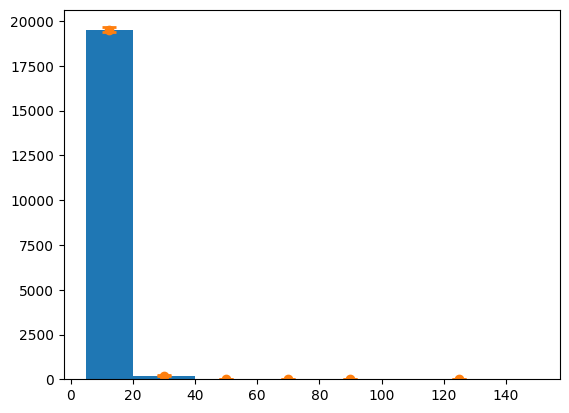

In [7]:
print(theta0_G)
print(theta0_G.shape)
print(binning)
print(len(binning))

print(plt.hist(binning[:-1], binning, weights=theta0_G))
print(len(binning[:-1]))
print(len(theta0_G_err))
plt.errorbar(bincenters, theta0_G, yerr=theta0_G_err, capsize=5, capthick=2, fmt='o', linestyle="None")
plt.show()

In [8]:
for iteration in range(n_iter):
    print(theta_unfolded[iteration])
    print(theta_unfolded_err[iteration])

[1.93383488e+04 1.81719908e+02 6.59796438e+00 3.33333333e+00
 0.00000000e+00 0.00000000e+00]
[138.75497042   9.62557632   1.38846221   1.56347192   0.
   0.        ]
[1.93488364e+04 1.70924407e+02 6.75581094e+00 3.48333873e+00
 0.00000000e+00 0.00000000e+00]
[139.1713691   13.54103806   2.17725965   1.95624432   0.
   0.        ]
[1.93533559e+04 1.66051230e+02 7.09049511e+00 3.50240501e+00
 0.00000000e+00 0.00000000e+00]
[139.37344249  15.25934458   2.87426063   2.06715535   0.
   0.        ]
[1.93553949e+04 1.63663544e+02 7.47913234e+00 3.46238629e+00
 0.00000000e+00 0.00000000e+00]
[139.46469578  16.09387063   3.52822801   2.11246061   0.
   0.        ]
[1.93563911e+04 1.62339711e+02 7.86645102e+00 3.40275958e+00
 0.00000000e+00 0.00000000e+00]
[139.5065413   16.58126378   4.13084712   2.14002517   0.
   0.        ]


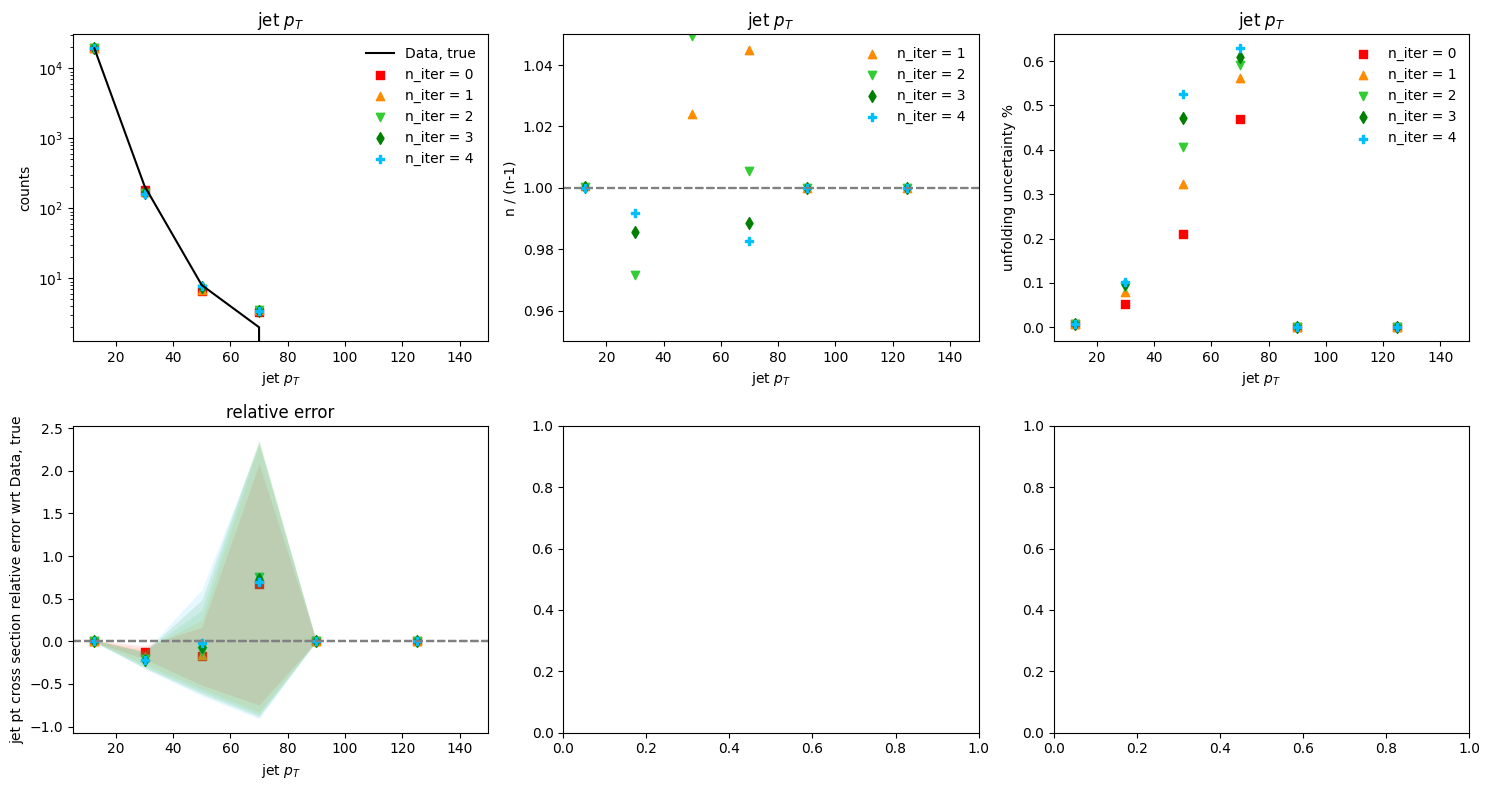

In [9]:
############################## UNFOLDED DISTRIBUTIONS ############################
# EEC distros

it = 5

fig, axes = plt.subplots(2, 3, figsize=(15,8))

pt_lims = [5, 150]

# COL 1: raw jet pt distribution WITH relative error over data, true underneath
ax = axes[0, 0]

ax.plot(bincenters, theta_unknown_G, color='black',label="Data, true")

for iteration in range(it):

    ax.scatter(bincenters, theta_unfolded[iteration],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
    ax.set_ylabel("counts")
    ax.set_yscale("log")
    
    ax.set_title(labels)
    ax.set_xlabel(labels)

    ax.legend(frameon=False)

    ax.set_xlim(pt_lims)

# row below with the error

ax = axes[1, 0]

ax.hlines(y=0, xmin=binning[0], xmax=binning[len(binning)-1], color='grey', linestyle='--')

for iteration in range(it):

    yvals, yerrs = get_ratio_safe(theta_unfolded[iteration], theta_unknown_G, \
                                      numerr=theta_unfolded_err[iteration], denomerr=theta_unknown_G_err, filler=1)
    yvals = yvals - 1

    ax.scatter(bincenters, yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.fill_between(bincenters, yvals-yerrs, yvals+yerrs, alpha=0.1, edgecolor=L_colors[iteration], facecolor=L_colors[iteration], linewidth=0)

    ax.hlines(y=0, xmin=binning[0], xmax=binning[len(binning)-1], color='grey', linestyle='--')
    
    ax.set_title("relative error")
    ax.set_xlabel(labels)
    ax.set_ylabel("jet pt cross section relative error wrt Data, true")

    #ax.set_ylim([-0.3, 0.3])
    ax.set_xlim(pt_lims)


# COL 2: convergence plot (n / n - 1)
ax = axes[0, 1]

for iteration in range(1,it):

    yvals = safe_divide(theta_unfolded[iteration], theta_unfolded[iteration-1], filler=1)
    ax.scatter(bincenters, yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.hlines(y=1, xmin=binning[0], xmax=binning[len(binning)-1], color='grey', linestyle='--')

    ax.set_title(labels)
    ax.set_xlabel(labels)
    ax.set_ylabel("n / (n-1)")
    ax.legend(frameon=False)

    ax.set_ylim([0.95, 1.05])
    ax.set_xlim(pt_lims)


# COL 3: statistical error %
ax = axes[0, 2]

for iteration in range(it):
    
    yvals = safe_divide(theta_unfolded_err[iteration], theta_unfolded[iteration])
    ax.scatter(bincenters, yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.set_title(labels)
    ax.set_xlabel(labels)
    ax.set_ylabel("unfolding uncertainty %")
    ax.legend(frameon=False)

    ax.set_xlim(pt_lims)


fig.tight_layout()
plt.show()
